<a href="https://colab.research.google.com/github/Blaisekhan/Capstone-project/blob/main/Capstone_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Importing Libraries
import numpy as np
import pandas as pd
import math
import json
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


In [6]:
#importing the updated dataset Amazon electronics ratings 2018
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Load dataset
ratings_electronics = pd.read_csv('/content/drive/MyDrive/Electronics/Electronics.csv', names=['ProductID', 'UserID','Rating', 'Timestamp'])


## **Exploring the Dataset**

In [6]:
#Snippet of dataset

ratings_electronics.head()


,ProductID,UserID,Rating,Timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400


In [7]:
#Print data shape in order to determine the subset needed for the analysis
ratings_electronics.shape

(20994353, 4)

In [ ]:
#Data types

ratings_electronics.dtypes

ProductID     object
UserID        object
Rating       float64
Timestamp      int64
dtype: object

In [23]:
#The dataset has 20,994,353 rows and 4 columns 
#Choosing a subset of the data using iLoc to select rows .iloc[<row_selection>, <column_selection>]

ratings_electronics = ratings_electronics.iloc[:5000000,0:]

ratings_electronics.shape








(5000000, 4)

In [ ]:
#information about the data

ratings_electronics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   ProductID  object 
 1   UserID     object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.0+ MB


In [ ]:
#Data summary
ratings_electronics.describe()['Rating']

count    2.000000e+06
mean     4.124842e+00
std      1.327276e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
#Saving subset to google drive

ratings_electronics.to_csv('/content/drive/MyDrive/Electronics/ratings_electronics.csv')



In [ ]:
#Checking for min and max ratings

print('The minimum rating is', ratings_electronics.Rating.min(),  'and the maximum rating is', 
      ratings_electronics.Rating.max(), 'which implies that the rating for the each product \nranges from 0 to 5')

The minimum rating is 1.0 and the maximum rating is 5.0 which implies that the rating for the each product 
ranges from 0 to 5


In [ ]:
#Checking for missing values 
print(ratings_electronics.isnull().sum())

Unnamed: 0    0
ProductID     0
UserID        0
Rating        0
Timestamp     0
dtype: int64


There is no missing value in the dataset. 

Text(0.5, 1.0, 'Ratings distribution')

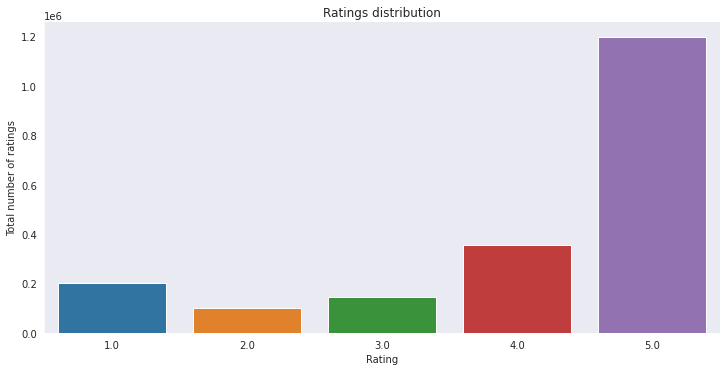

In [ ]:
#Display the distribution of customer ratings
with sns.axes_style('dark'):
  gh = sns.factorplot("Rating", data=ratings_electronics, aspect=2.0, kind='count')
  gh.set_ylabels("Total number of ratings")
  plt.title("Ratings distribution")

From the distribution above, most customers gave a 5 star rating to electronics on amazon's store. 

In [18]:
#Getting the total number of customers and products reviewed in the data subset 
print("Total number of unique customers and rated products\n","_"*60)
print("Unique users: ", len(np.unique(ratings_electronics.UserID)))
print("Total number of rated products: ", len(np.unique(ratings_electronics.ProductID)))
print("Total number of ratings: ", ratings_electronics.shape[0])

Total number of unique customers and rated products
 ____________________________________________________________
Unique users:  2926618
Total number of rated products:  50935
Total number of ratings:  5000000


1,450,854 customers provided 2 million ratings for 24,216 products

In [10]:
#Dropping columns not needed in the analysis 
del ratings_electronics['Timestamp']


In [11]:
ratings_electronics.head()

,ProductID,UserID,Rating
0,0060009810,A1N070NS9CJQ2I,5.0
1,0060009810,A3P0KRKOBQK1KN,5.0
2,0060009810,A192HO2ICJ75VU,5.0
3,0060009810,A2T278FKFL3BLT,4.0
4,0060009810,A2ZUXVTW8RXBXW,5.0


In [10]:
#Determing the number of ratings provided by each user

rates_per_user=ratings_electronics.groupby(by='UserID')['Rating'].count().sort_values(ascending=False)
rates_per_user.head()

UserID
A5JLAU2ARJ0BO     275
A6FIAB28IS79      174
A231WM2Z2JL0U3    172
A3OXHLG6DIBRW8    140
A680RUE1FDO8B     121
Name: Rating, dtype: int64

From the data subset that is going to be used in building the recommendation system, the most ratings provided by one customer is 275.

## **Popularity-Based Recommendation**

This system utilizes the popularity characteristics of products as popularity of a product greatly influences consumer purchasing decisions and often represents important characteristics of a product.

One major setback with this method is that, it can't be personalized. 

In [24]:
#Downsizing dataframe to only contain products that received 50 ratings and above
most_rates = ratings_electronics.groupby("ProductID").filter(lambda x:x["Rating"].count()>=50)


Downsized the dataframe to only contain products that received 50 ratings and above. 

In [25]:
most_rates.head()
most_rates.shape

,ProductID,UserID,Rating,Timestamp
284,0511189877,A3J3BRHTDRFJ2G,2.0,1397433600
285,0511189877,A1QGNMC6O1VW39,5.0,1397433600
286,0511189877,A2TY0BTJOTENPG,5.0,1395878400
287,0511189877,A34ATBPOK6HCHY,5.0,1395532800
288,0511189877,A89DO69P0XZ27,5.0,1395446400


(4471445, 4)

Text(0.5, 1.0, 'Rating Per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'Ratings per product')

[]

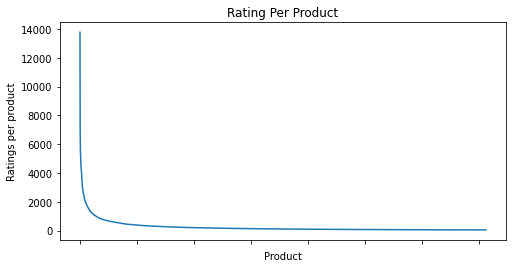

In [ ]:
#plotting the rating per product
ratings_per_pdt = most_rates.groupby("ProductID")["Rating"].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(ratings_per_pdt.values)
plt.title("Rating Per Product")
plt.xlabel('Product')
plt.ylabel('Ratings per product')
ax.set_xticklabels([])

plt.show()

In [17]:
#Average product rating 

avg_rate_per_pdt = most_rates.groupby('ProductID')['Rating'].mean()
avg_rate_per_pdt.head()

ProductID
0060786817    3.666667
0101635370    2.985294
0151004714    3.583333
0511189877    4.266667
0528881469    3.020833
Name: Rating, dtype: float64

In [15]:
ratings_per_pdt = most_rates.groupby("ProductID")["Rating"].count()
ratings_per_pdt.head()


ProductID
0060786817     45
0101635370     68
0151004714     48
0511189877    105
0528881469     48
Name: Rating, dtype: int64

To determine the final rating of a product, add all the ratings users gave that product to get the average 

In [ ]:
#Getting the products with the highest Average rating 

most_rates.groupby('ProductID')['Rating'].mean().sort_values(ascending = False).head()

ProductID
B000HARV82    5.000000
B00008VSKS    5.000000
B00000J0MS    4.997494
B000TMFYBO    4.963636
B00009XVL7    4.941176
Name: Rating, dtype: float64

Products B000HARV82 and B00008VSKS got 5 stars from all customers that rated the product. This is a good indicator for the seller to put more of these products on their shelves or website. 5 star rating is a good feedback from customers indicating either their satisfaction or how valuable they found the product or service. 

In [ ]:
#Total number of ratings received by each product

most_rates.groupby('ProductID')['Rating'].count().sort_values(ascending=False).head()

ProductID
B000BQ7GW8    13768
B000HPV3RW     9406
B0006BB9MG     7593
B000FNFSPY     6927
B000A6PPOK     6398
Name: Rating, dtype: int64

Product B000BQ7GW8 received 13768 ratings which is the most ratings received by a single product.

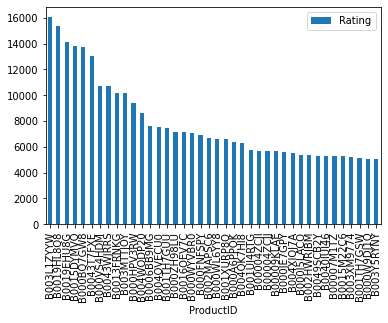

In [18]:
#Popular products based on total number of ratings provided by customers 

pop_pdts = pd.DataFrame(most_rates.groupby('ProductID')['Rating'].count())
most_pop = pop_pdts.sort_values('Rating', ascending = False)
most_pop.head(40).plot(kind='bar')

The plot above shows the top 40 popular electronics on Amazon's online store based on the number of rating provided by customers. 

In [13]:
#Creating a new Dataframe that contains the ProductID, 
#Average rating(Rating) and total rating(Ratings_count) received by each product

avg_total_rating = pd.DataFrame(most_rates.groupby('ProductID')['Rating'].mean())

In [14]:
avg_total_rating['Ratings_Count'] = pd.DataFrame(most_rates.groupby('ProductID')['Rating'].count())

In [15]:
avg_total_rating.head()

,Rating,Ratings_Count
ProductID,,
0101635370,2.985294,68
0511189877,4.266667,105
0545105668,4.692308,52
0594033926,4.634146,82
0594459451,4.540323,124


In [16]:
avg_total_rating.shape

(15497, 2)

<Figure size 576x432 with 0 Axes>

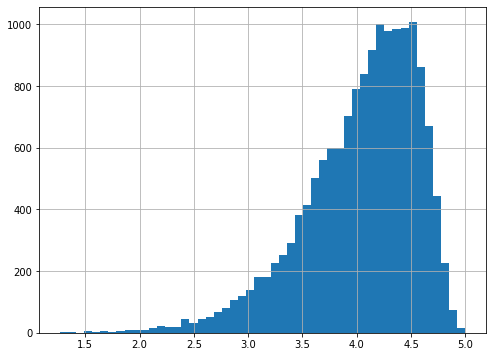

In [17]:
plt.figure(figsize=(8,6))
avg_total_rating['Rating'].hist(bins=50)

Most of the products which received 45 ratings and above had an average rating of between 4.3 and 4.5

<Figure size 576x432 with 0 Axes>

Text(0.5, 0.98, 'Ratings VS Ratings_Received')

<Figure size 576x432 with 0 Axes>

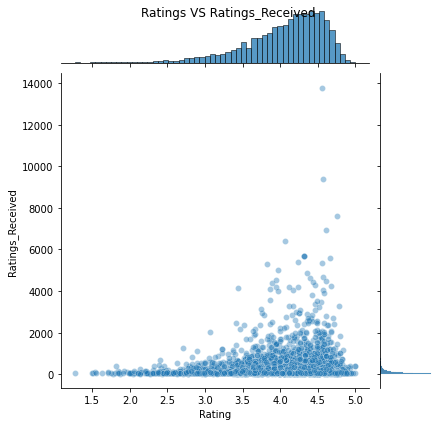

In [ ]:
#Ratings Vs Ratings received 
plt.figure(figsize=(8,6))
p = sns.jointplot(x='Rating', y='Ratings_Received', data= avg_total_rating, alpha=0.4)
p.fig.suptitle('Ratings VS Ratings_Received')

From the figure above, the products with ratings between 4.3 to 4.5 received the most reviews from buyers. The amount of reviews given begins to drop as the rating moves closer to 5 stars. 

In [23]:
C = avg_total_rating['Rating'].mean()
print(C)

4.038220352416257


In [20]:
m = avg_total_rating['Ratings_Count'].quantile(0.25)
print(m )

74.0


In [22]:
pdts = avg_total_rating.copy().loc[avg_total_rating['Ratings_Count']>=m]
pdts.shape

(11739, 2)

In [26]:
def weighted_rating(x, m=m, C=C):
  v = x['Ratings_Count']
  r = x['Rating']
  return (v/(v+m)*r)+(m/(m+v)*C)

In [27]:
avg_total_rating['score'] = avg_total_rating.apply(weighted_rating, axis=1)



In [29]:
avg_total_rating = avg_total_rating.sort_values('score', ascending=False)

avg_total_rating.head()

,Rating,Ratings_Count,score
ProductID,,,
B00008VSKS,5.000000,394,4.847924
B00000J0MS,4.997494,399,4.847417
B003L1AINY,5.000000,328,4.822956
B0043WJRRS,4.807019,10685,4.801731
B004Y1AYAC,4.833522,1766,4.801537


# Collaborative Filtering (Item-based approach)
Collaborative Filtering is the process of filtering or evaluating items using other people's opinions.
Item-based filtering was developed by Amazon.
It is more faster and stable than the user-based filtering in system where there are more users than items.

In [9]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 6.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617576 sha256=6524a2b96a9609b490348e0f687a84d82c2bcc5b77681d32e85c64d3fd340e71
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
most_rates.head()
most_rates.shape


,ProductID,UserID,Rating
7,0060786817,A2UNA438B0FRA8,5.0
8,0060786817,A2NQQSHSQKKGEX,5.0
9,0060786817,A5EXND10WD4PM,3.0
10,0060786817,AVJ37XQN3ID16,5.0
11,0060786817,A21NVBFIEQWDSG,4.0


(1770083, 3)

In [ ]:
#reading the dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(most_rates,reader)


In [ ]:
#Splitting the dataset into Trainset/Testset

trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

In [ ]:
cf_algo = KNNWithMeans(k=5, sim_options={'name':'pearson_baseline', 'user_based': False})
cf_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...


In [ ]:
#Predict
pred_test = cf_algo.test(testset)

In [ ]:
pred_test

In [ ]:
#Accuracy of the model - RMSE
accuracy.rmse(pred_test, verbose=True)


# **Model-Based Collaborative Filtering**

Using machine learning to train models to make predictions 



In [ ]:
pip install scikit-surpris

In [32]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split


In [ ]:
#Downsizing dataframe to only contain products that received 50 ratings and above
most_rates = ratings_electronics.groupby("ProductID").filter(lambda x:x["Rating"].count()>=50)

In [26]:
e_rating = most_rates.head(200000)

In [27]:
e_rating.shape

(200000, 4)

In [28]:
#Dropping the Timestamp column as it won't be needed in our analysis

del e_rating['Timestamp']


In [30]:
e_rating.head()

,ProductID,UserID,Rating
284,0511189877,A3J3BRHTDRFJ2G,2.0
285,0511189877,A1QGNMC6O1VW39,5.0
286,0511189877,A2TY0BTJOTENPG,5.0
287,0511189877,A34ATBPOK6HCHY,5.0
288,0511189877,A89DO69P0XZ27,5.0


Splitting the data into Test and train sets


In [34]:
#reading the dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(e_rating,reader)

In [35]:

trainset, testset = train_test_split(data, test_size = .20)

Building model

In [ ]:
#Implimenting SVD 
model = SVD()